In [33]:
#importing all necessary libraries and modules

import numpy as np
#import pandas pd
import matplotlib.pyplot as plt
import pickle

In [65]:
class lammpstrj_analysis:
    
    def __init__(self,filename,dt=1):
        self.filename=filename
        #self.tstart,self.no_atoms,self.xlo,self.xhi,self.ylo,self.yhi,self.zlo,self.zhi=self.initialization()
        self.trj={}
        self.dr={}
        self.tstart=1
        self.tdiff=1
        
    def initialization(self):
        file=open(self.filename,"r")
        file.readline() #itemline
        init_time=int(file.readline().replace("\n",""))
        file.readline() #item no of atoms
        no_atoms=int(file.readline().replace("\n",""))
        file.readline() # box bounds
        xlo,xhi=map(float,file.readline().replace("\n","").split(" "))
        ylo,yhi=map(float,file.readline().replace("\n","").split(" "))
        zlo,zhi=map(float,file.readline().replace("\n","").split(" "))
        file.close()
        return init_time,no_atoms,xlo,xhi,ylo,yhi,zlo,zhi
    
    def read_trj(self):
        tstart=-5
        tsecond=-5
        frames=0
        f=open(self.filename,"r")
        
        while f.read(2)!="": #condition of file ending
            f.readline().replace("\n","")  #skipping 1st line
            tstep=int(f.readline().replace("\n",""))#tstep
    
            # Calculate tdiff==================
            if tstart<0:
                tstart=tstep
            elif tstart>=0 and tsecond <0:
                tsecond = tstep
            self.tstop=tstep
            self.tdiff=tsecond-tstart
            #===================================
            #print("time step present",tstep)
            
            for i in range(7):
                f.readline().replace("\n","")   #skipping lines
        
            for i in range(0,self.no_atoms):            #loop to go through all atoms
                a=f.readline().replace("\n","").split(" ")  
                atom_id=int(a[0])
                atom_type=int(a[1])
                x=float(a[2])
                y=float(a[3])
                z=float(a[4])
                
                if atom_type not in self.trj:
                    self.trj[atom_type]={}
                    self.trj[atom_type][atom_id]={}
                else:
                    if atom_id not in self.trj[atom_type]:
                        self.trj[atom_type][atom_id]={}
                self.trj[atom_type][atom_id][tstep]=np.zeros(3,dtype=float)
    

                self.trj[atom_type][atom_id][tstep][0]=x
                self.trj[atom_type][atom_id][tstep][1]=y
                self.trj[atom_type][atom_id][tstep][2]=z
            frames+=1
        f.close()
        return frames
        
    def cal_dr(self,atom_type,atom_id,skip=1):
        temp=self.trj[atom_type][atom_id]
        dr={}
        for i in range(self.tstart,self.tstop-skip*self.tdiff+1,self.tdiff*skip):
            for j in range(i,self.tstop+1,self.tdiff*skip):
                dt=j-i
                dr2=(temp[j][0]-temp[i][0])**2+(temp[j][1]-temp[i][1])**2+(temp[j][2]-temp[i][2])**2
                if dt not in dr:
                    dr[dt]=[]
                dr[dt].append(dr2)
        return dr
    
    def mean_dr(self,dr):
        mean_dr=np.zeros((len(dr),2),dtype=float)
        j=0
        for i in dr:
            mean_dr[0+j,0]=i
            mean_dr[0+j,1]=sum(dr[i])/len(dr[i])
            j+=1
        return mean_dr
    
    def cal_msd(self,atom_type,atom_id,skip=1):
        msd=self.mean_dr(self.cal_dr(atom_type,atom_id,skip))
        #self.save_output(msd,"id"+str(atom_id)+"msd.txt")
        return msd
        
    
    def save_dict_to_file(self,data_dict, file_path):
        with open(file_path, 'wb') as file:
            pickle.dump(data_dict, file)
            
    def save_output(self,data, file_path):
        np.savetxt(file_path,data)
            
    def plotting(self):
        pass
        
    def cal_avg(self,atom_type,atom_ids,skip=1):
        if isinstance(atom_ids, int):
                atom_ids=self.trj[atom_type].keys()
        init=True
        count=0
        for i in atom_ids:
            count+=1
            if init==True:
                msd=self.mean_dr(self.cal_dr(atom_type,i,skip))
                init=False
            else:
                temp=self.mean_dr(self.cal_dr(atom_type,i,skip))
                msd=temp+msd
        return msd/count  
            
    def main(self):
        
        self.read_trj()
        for i in (1,449):
            msd=self.mean_dr(self.cal_dr(1,i))
            self.save_output(msd,"msd.txt")
            
    def vasp_init(self):
        file=open(self.filename,"r")
        file.readline()
        self.scale=int(file.readline().replace("\n",""))
        a1,a2,a3=map(float,file.readline().replace("\n","").split())
        b1,b2,b3=map(float,file.readline().replace("\n","").split())
        c1,c2,c3=map(float,file.readline().replace("\n","").split())
        ele_name=list(map(str,file.readline().replace("\n","").split()))
        ele_num=list(map(int,file.readline().replace("\n","").split()))
        file.close()
        ele_dict={}
        for i in range(len(ele_name)):
            ele_dict[ele_name[i]]=ele_num[i]
        self.ele_dict=ele_dict
        
    def read_xdatcar(self):
        f=open(self.filename,"r")
        for i in range(7):
            f.readline()
        for i in self.ele_dict.keys():
            self.trj[i]={}
        for i in self.ele_dict.keys():
            for j in range(self.ele_dict[i]):
                self.trj[i][j]={}
        
        while f.read(2)!="": #condition of file ending
            tstep=int((f.readline().replace("\n","").split())[2])#skipping 1st line
            self.tstop=tstep
            for i in self.ele_dict.keys():
                for j in range(self.ele_dict[i]):
                    x,y,z=map(float,f.readline().replace("\n","").split())
                    self.trj[i][j][tstep]=np.array([x,y,z])
            

In [74]:
a=lammpstrj_analysis("XDATCAR")
a.vasp_init()

In [75]:
a.ele_dict


{'Li': 6, 'Ge': 12, 'P': 18, 'O': 72}

In [76]:
a.read_xdatcar()

In [77]:
a.trj

{'Li': {0: {1: array([0.333333, 0.666667, 0.166667]),
   2: array([0.33292924, 0.66705838, 0.16656474]),
   3: array([0.33253519, 0.66742198, 0.16648522]),
   4: array([0.33216232, 0.66773364, 0.1664493 ]),
   5: array([0.3318217 , 0.66797592, 0.16647222]),
   6: array([0.33152297, 0.66813929, 0.16656158]),
   7: array([0.33127456, 0.66822022, 0.16671661]),
   8: array([0.33108494, 0.6682212 , 0.16692918]),
   9: array([0.33096249, 0.66814759, 0.16718641]),
   10: array([0.33091532, 0.66800582, 0.16747272]),
   11: array([0.33095032, 0.66780021, 0.16777302]),
   12: array([0.33107105, 0.66753043, 0.16807463]),
   13: array([0.33127638, 0.66718892, 0.16836941]),
   14: array([0.33155912, 0.66675856, 0.16865421]),
   15: array([0.3319062 , 0.6662121 , 0.16893003]),
   16: array([0.33229847, 0.66551248, 0.1692014 ]),
   17: array([0.33271259, 0.66461591, 0.16947417]),
   18: array([0.33312187, 0.66347521, 0.16975325]),
   19: array([0.33349947, 0.66204746, 0.17003913]),
   20: array([0.33

In [78]:
p=a.cal_avg("Li",range(6))

In [20]:
msd=a.cal_avg(1,0,20)

In [23]:
np.save("MSD.npy",msd)

Help on function save in module numpy:

save(file, arr, allow_pickle=True, fix_imports=True)
    Save an array to a binary file in NumPy ``.npy`` format.
    
    Parameters
    ----------
    file : file, str, or pathlib.Path
        File or filename to which the data is saved.  If file is a file-object,
        then the filename is unchanged.  If file is a string or Path, a ``.npy``
        extension will be appended to the filename if it does not already
        have one.
    arr : array_like
        Array data to be saved.
    allow_pickle : bool, optional
        Allow saving object arrays using Python pickles. Reasons for disallowing
        pickles include security (loading pickled data can execute arbitrary
        code) and portability (pickled objects may not be loadable on different
        Python installations, for example if the stored objects require libraries
        that are not available, and not all pickled data is compatible between
        Python 2 and Python 3).
  

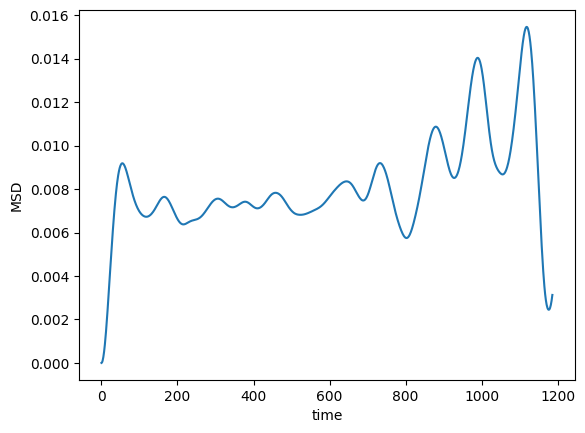

In [79]:
plt.plot(p[:,0],p[:,1])
plt.xlabel("time")
plt.ylabel("MSD")
plt.savefig("MSD.png")